# Heterogeneity in Dahu

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(archive.read(csv_name)), names=columns)
    df.columns = df.columns.str.strip()
    return df

directory = 'heterogeneity_exp/4'

In [2]:
import os
import yaml
import re

pattern = re.compile('result_monocore_(\d?\d).csv')


def read_file(archive_name, csv_name, columns=None):
    df = read_csv(archive_name, csv_name, columns)
    info = yaml.load(zipfile.ZipFile(archive_name).read('info.yaml'))
    nodes = [key for key in info if key.endswith('grid5000.fr')]
    assert len(nodes) == 1
    node = nodes[0]
    node = node[:node.index('.')]
    node = int(node[node.index('-')+1:])
    df['node'] = node
    df['index'] = range(len(df))
    df['index_in_seq'] = df['index'] % 3
    df['first_index'] = df['index_in_seq'] == 0
    match = pattern.match(csv_name)
    assert match
    core_index = int(match.groups()[0])
    df['core'] = core_index
    return df

def read_archive(archive_name, columns=None):
    data = []
    for file in zipfile.ZipFile(archive_name).namelist():
        if pattern.match(file):
            data.append(read_file(archive_name, file, columns=columns))
    return pandas.concat(data)

def read_dir(directory, columns=None):
    data = []
    for file in os.listdir(directory):
        if file.endswith('.zip'):
            data.append(read_archive(os.path.join(directory, file), columns=columns))
    return pandas.concat(data, ignore_index=True)

columns = ['function', 'm', 'n', 'k', 'timestamp', 'duration']

df_monocore = read_dir(directory, columns)

for df in [df_monocore]:
    df['size_cube'] = -1
    df.m = df.m.astype(float)
    df.n = df.n.astype(float)
    df.k = df.k.astype(float)
    df.loc[df.function == 'dtrsm', 'size_cube'] = df.m * df.n**2
    df.loc[df.function == 'dgemm', 'size_cube'] = df.m * df.n * df.k

print(len(df_monocore))
df_monocore.head()

245760


,function,m,n,k,timestamp,duration,node,index,index_in_seq,first_index,core,size_cube
0,dtrsm,4.0,4.0,-1.0,754.354737,3.476000e-06,21,0,0,True,0,6.400000e+01
1,dtrsm,4.0,4.0,-1.0,754.354763,5.430000e-07,21,1,1,False,0,6.400000e+01
2,dtrsm,4.0,4.0,-1.0,754.354766,2.500000e-07,21,2,2,False,0,6.400000e+01
3,dtrsm,4000.0,4000.0,-1.0,754.354768,2.165907e+00,21,3,0,True,0,6.400000e+10
4,dtrsm,4000.0,4000.0,-1.0,756.520683,2.168003e+00,21,4,1,False,0,6.400000e+10


In [3]:
assert set(df_monocore['node'].unique()) == set(range(1, 33))
for node in df_monocore['node'].unique():
    df = df_monocore[df_monocore['node'] == node]
    assert set(df['core'].unique()) == set(range(0, 32))

## Anova

In [4]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def my_anova(df, factors, response):
    f_str = ['C(%s)' % fact for fact in factors if len(df[fact].unique()) > 1]
    formula = ' + '.join(f_str)
    formula = '(%s)**2' % formula
    formula = '%s ~ %s' % (response, formula)
    model = ols(formula, df).fit()
    aov_table = anova_lm(model, typ=2)
    aov_table['stars'] = ''
    aov_table.loc[aov_table['PR(>F)'] < 0.1 ,  'stars'] = '.'
    aov_table.loc[aov_table['PR(>F)'] < 0.05,  'stars'] = '*'
    aov_table.loc[aov_table['PR(>F)'] < 0.01,  'stars'] = '**'
    aov_table.loc[aov_table['PR(>F)'] < 0.001, 'stars'] = '***'
    return aov_table

def compute_anova(df, function, m):
    df = df[(df['function'] == function) & (df['m'] == m)]
    return my_anova(df, factors=['node', 'core', 'first_index'], response='duration')

In [5]:
compute_anova(df_monocore, 'dtrsm', 4)

,sum_sq,df,F,PR(>F),stars
C(node),2.641095e-11,31.0,1.497787,3.702473e-02,*
C(core),5.135763e-10,31.0,29.125342,1.914713e-168,***
C(first_index),3.740001e-08,1.0,65750.573486,0.000000e+00,***
C(node):C(core),7.238032e-10,961.0,1.324113,7.324619e-11,***
C(node):C(first_index),3.650464e-11,31.0,2.070209,4.245764e-04,***
C(core):C(first_index),8.190788e-10,31.0,46.450647,5.684538e-280,***
Residual,3.432978e-08,60353.0,NaN,NaN,


In [6]:
compute_anova(df_monocore, 'dgemm', 4)

,sum_sq,df,F,PR(>F),stars
C(node),1.474393e-11,31.0,1.062638,3.722615e-01,
C(core),2.205891e-10,31.0,15.898501,3.500191e-84,***
C(first_index),2.168803e-08,1.0,48456.706489,0.000000e+00,***
C(node):C(core),3.627535e-10,961.0,0.843377,9.998348e-01,
C(node):C(first_index),1.996726e-11,31.0,1.439098,5.401454e-02,.
C(core):C(first_index),4.212147e-10,31.0,30.358166,2.315774e-176,***
Residual,2.701252e-08,60353.0,NaN,NaN,


In [7]:
compute_anova(df_monocore, 'dtrsm', 4000)

,sum_sq,df,F,PR(>F),stars
C(node),47.203688,31.0,55963.160135,0.000000e+00,***
C(core),27.482925,31.0,32582.863352,0.000000e+00,***
C(first_index),0.030390,1.0,1116.893183,1.169712e-242,***
C(node):C(core),61.624421,961.0,2356.771377,0.000000e+00,***
C(node):C(first_index),0.018884,31.0,22.388440,2.565398e-125,***
C(core):C(first_index),0.003795,31.0,4.499533,1.092145e-15,***
Residual,1.642143,60353.0,NaN,NaN,


In [8]:
compute_anova(df_monocore, 'dgemm', 4000)

,sum_sq,df,F,PR(>F),stars
C(node),165.285530,31.0,64170.947456,0.000000e+00,***
C(core),95.108041,31.0,36925.029481,0.000000e+00,***
C(first_index),0.057543,1.0,692.556815,8.975716e-152,***
C(node):C(core),213.255116,961.0,2670.800078,0.000000e+00,***
C(node):C(first_index),0.041828,31.0,16.239578,2.505617e-86,***
C(core):C(first_index),0.009827,31.0,3.815309,4.147190e-12,***
Residual,5.014568,60353.0,NaN,NaN,


From the ANOVA, we see that:
- With a small matrix, the biggest factor is by far `first_index`, showing that we have a very significant warm-up.
- With a large matrix, the biggest factors are by far `node`, `core` and `node:core`, it seems we have a very significant heterogeneity.

## Removing the first call

Let's see if we should throw away the first call.

In [9]:
df_monocore.groupby(['function', 'm', 'index_in_seq'])[['duration']].agg(['mean', 'std'])

duration              
                                      mean           std
function m      index_in_seq                            
dgemm    4.0    0             1.576351e-06  1.164301e-06
                1             3.348258e-07  6.466018e-08
                2             2.971788e-07  9.642269e-08
         4000.0 0             4.124272e+00  8.952927e-02
                1             4.122869e+00  8.796467e-02
                2             4.121568e+00  8.730276e-02
dtrsm    4.0    0             1.895828e-06  1.314293e-06
                1             2.752264e-07  1.465510e-07
                2             2.062881e-07  1.691483e-07
         4000.0 0             2.150155e+00  4.665674e-02
                1             2.151078e+00  4.744077e-02
                2             2.152217e+00  4.805522e-02

Ok, let's remove the first call.

In [10]:
df_monocore = df_monocore[~df_monocore['first_index']]
df_monocore.groupby(['function', 'm'])[['duration']].agg(['mean', 'std'])

duration              
                         mean           std
function m                                 
dgemm    4.0     3.160023e-07  8.422177e-08
         4000.0  4.122219e+00  8.763569e-02
dtrsm    4.0     2.407573e-07  1.619621e-07
         4000.0  2.151647e+00  4.775180e-02

## Metrics of interest

For each matrix size and each function:
- mean and standard deviation on all the calls,
- mean and standard deviation per node,
- mean and standard deviation per node and core,
- mean of sd and sd of means per node,
- mean of sd and sd of means per node and core.

In [11]:
def reset_index(df):
    df = df.copy()
    df.columns = df.columns.droplevel()
    return df.reset_index()

def summary(df, group, res_index=True):
    agg = df.groupby(group)[['duration']].agg(['mean', 'std', 'min', 'max'])
    if res_index:
        agg = reset_index(agg)
    return agg

def summary_plot(df, function, m, color=None):
    df = df[(df['function'] == function) & (df['m'] == m)]
    agg = summary(df, 'node')
    plot = ggplot() + theme_bw()
    aesthetic = {'x': 'node', 'y': 'duration'}
    if color:
        aesthetic['color'] = color
    plot += geom_point(df, aes(**aesthetic), alpha=0.1)
    plot += geom_point(agg, aes(x='node', y='mean'), size=2, shape=0, color='red')
    plot += ggtitle('Durations (per node) of function %s with a matrix size of %d' % (function, m))
    return plot

In [12]:
def summary_plot_node(df, function, m, node):
    df = df[(df['function'] == function) & (df['m'] == m) & (df['node'] == node)]
    plot = ggplot(df) + theme_bw()
    print(plot + geom_point(aes(x='index', y='duration')) + ggtitle('Durations for node dahu-%d during the experiment' % node))
    print(plot + geom_point(aes(x='core', y='duration')) + ggtitle('Durations for node dahu-%d per core' % node))

### DGEMM, N=4000

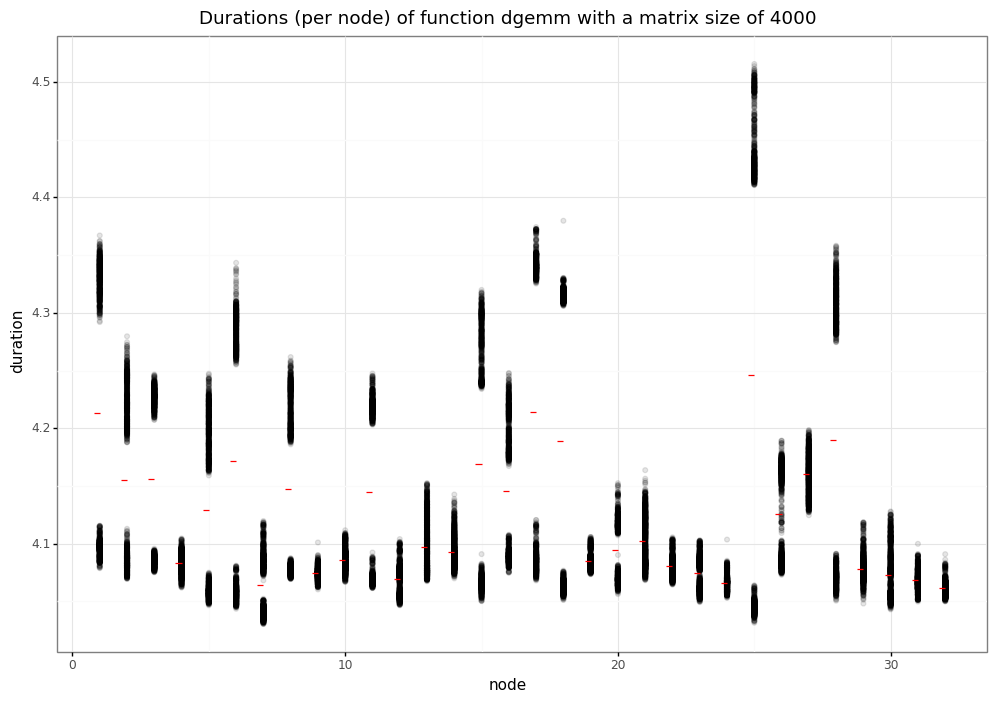

<ggplot: (8762825035882)>

In [13]:
summary_plot(df_monocore, 'dgemm', 4000)

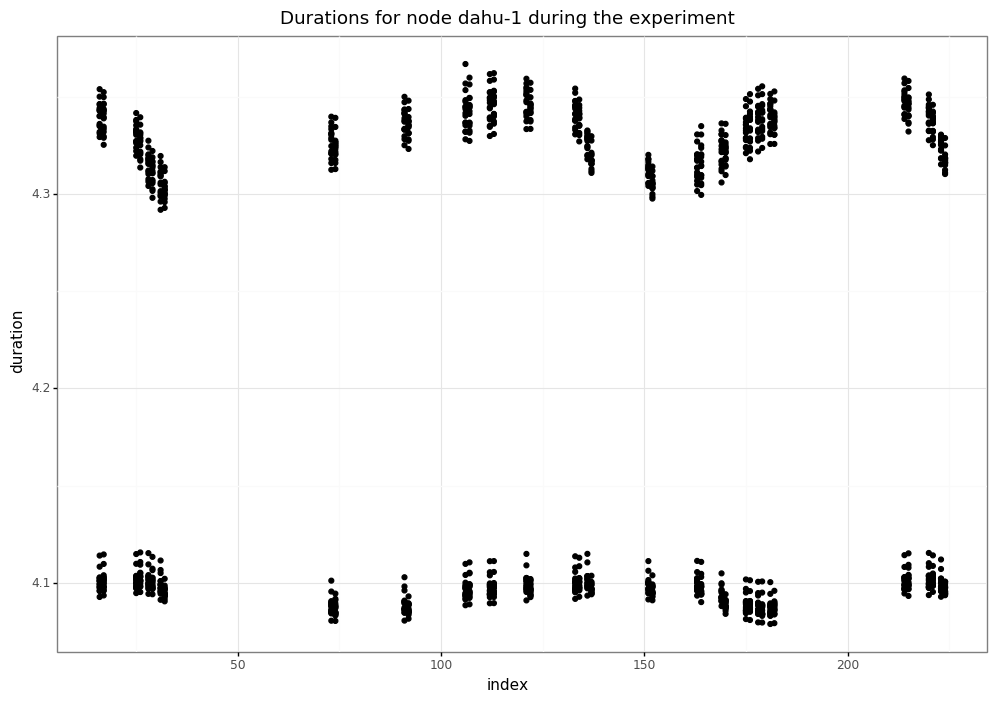

<ggplot: (-9223363274030594942)>


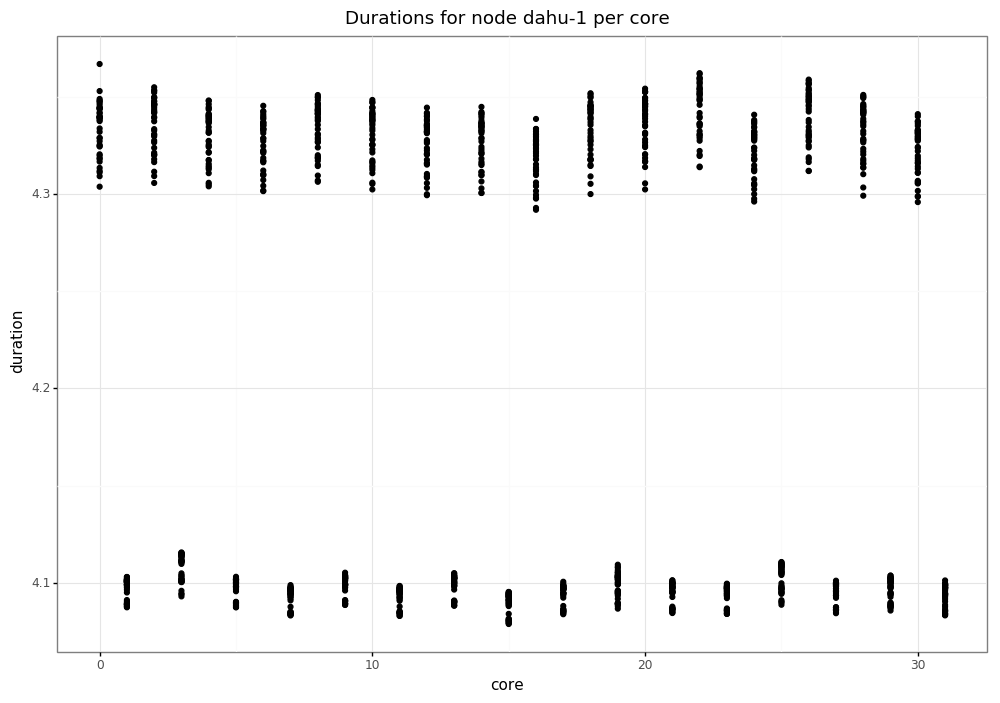

<ggplot: (-9223363274030596159)>


In [14]:
summary_plot_node(df_monocore, 'dgemm', 4000, 1)

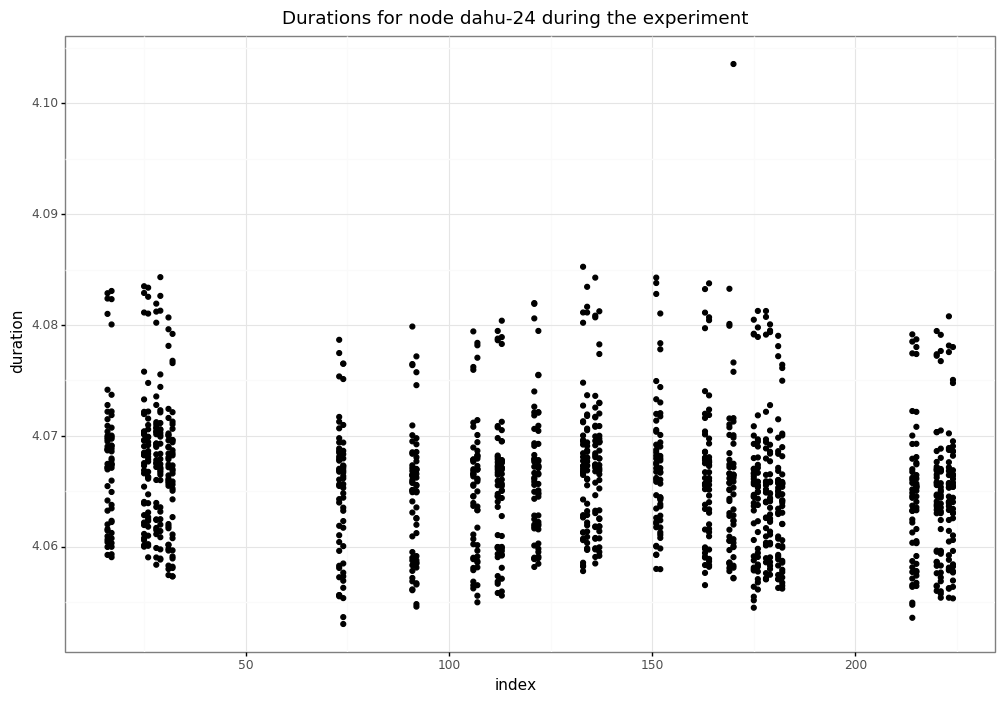

<ggplot: (-9223363274030602408)>


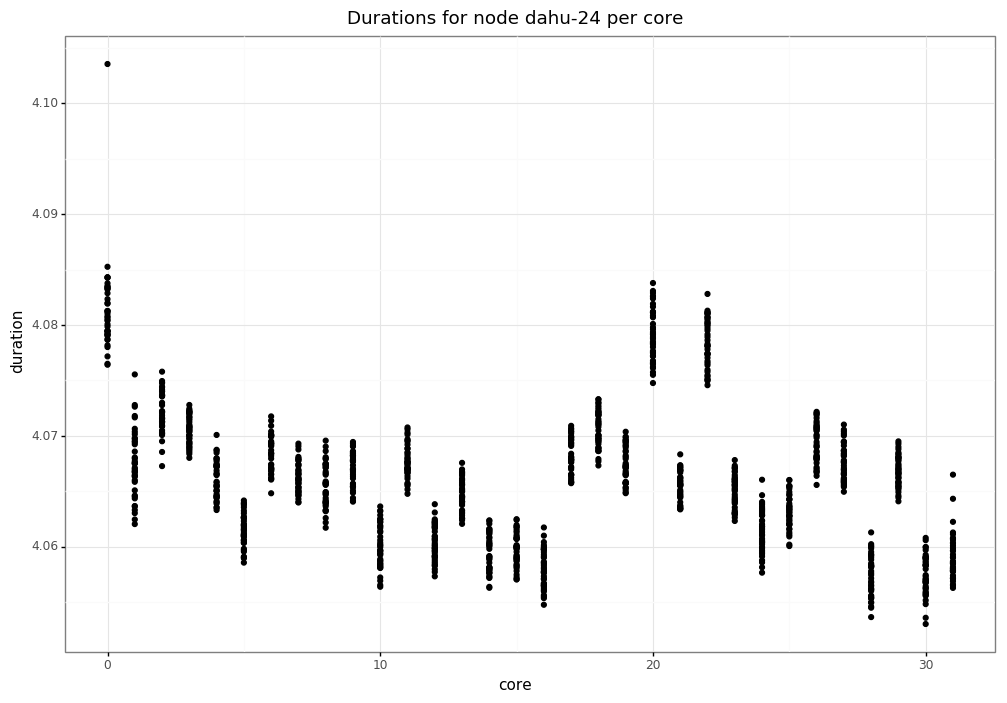

<ggplot: (-9223363274030620707)>


In [15]:
summary_plot_node(df_monocore, 'dgemm', 4000, 24)

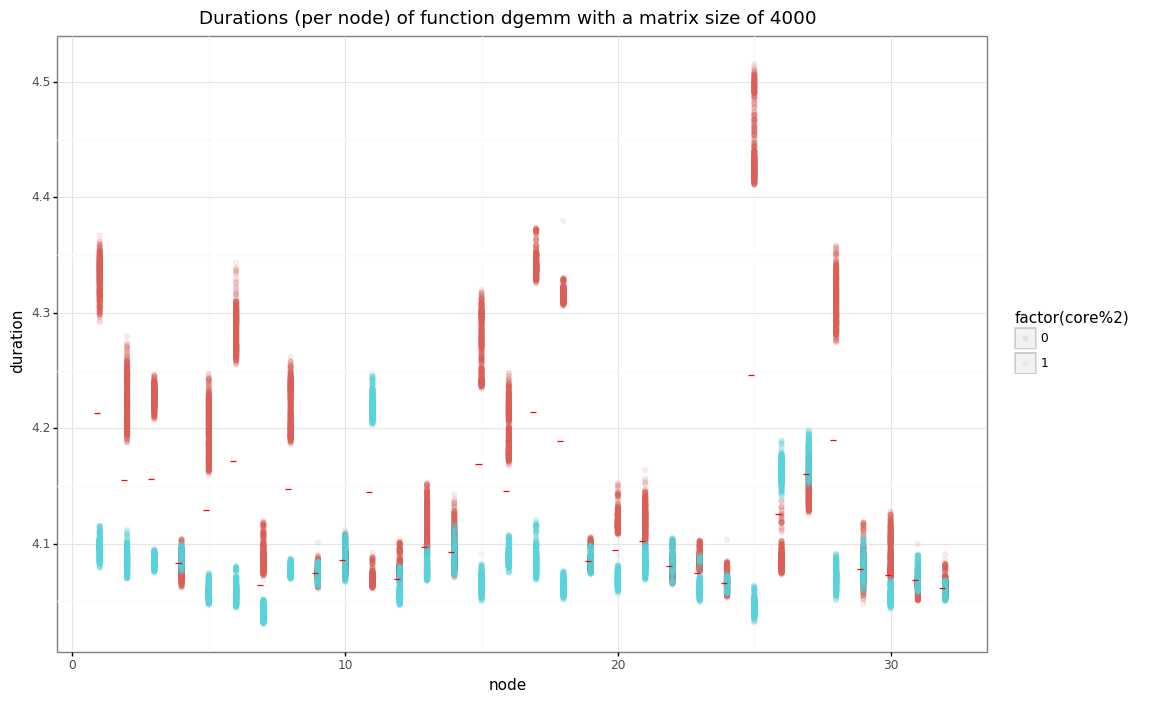

<ggplot: (-9223363274030637680)>

In [16]:
df_monocore['core%2'] = df_monocore['core']%2
summary_plot(df_monocore, 'dgemm', 4000, color='factor(core%2)')

### DTRSM, N=4000

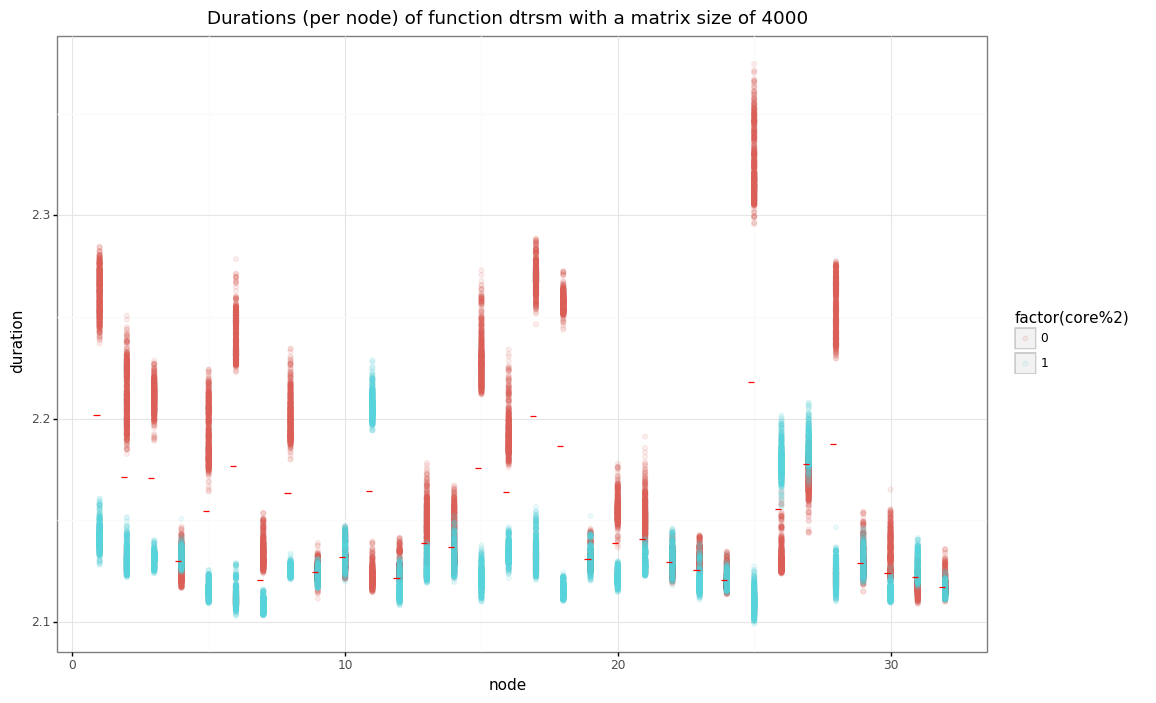

<ggplot: (8762824263670)>

In [17]:
summary_plot(df_monocore, 'dtrsm', 4000, color='factor(core%2)')

### DGEMM, N=4

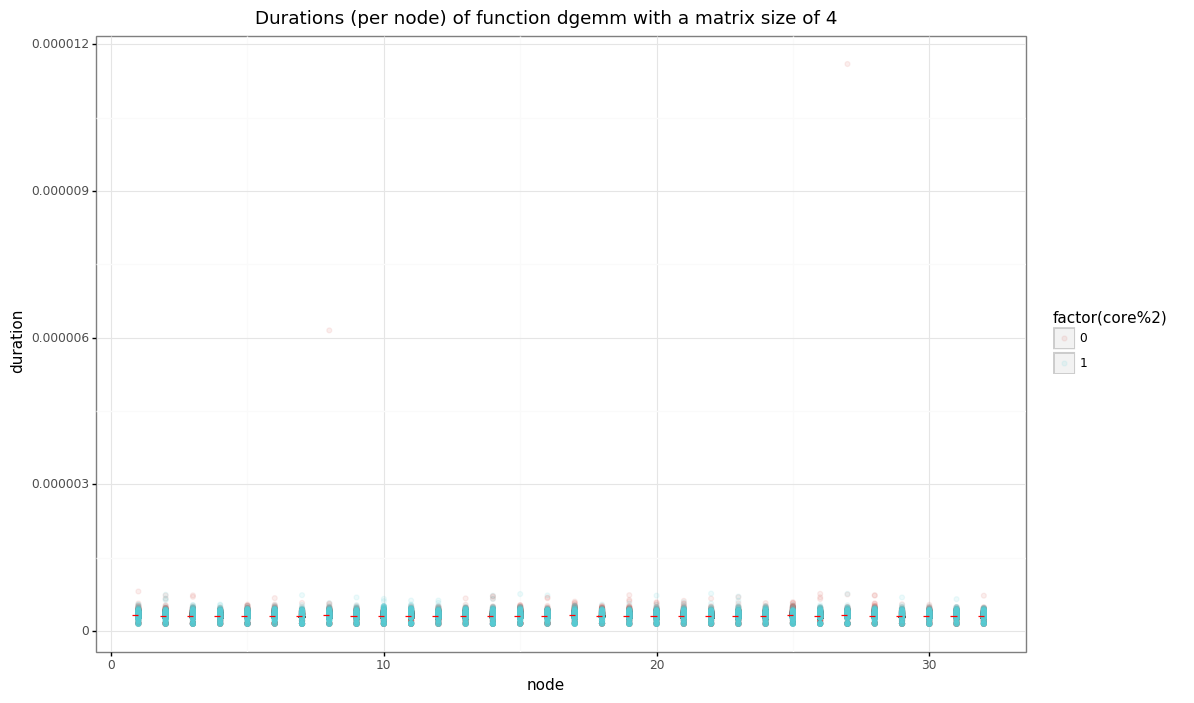

<ggplot: (-9223363274029739937)>

In [18]:
summary_plot(df_monocore, 'dgemm', 4, color='factor(core%2)')

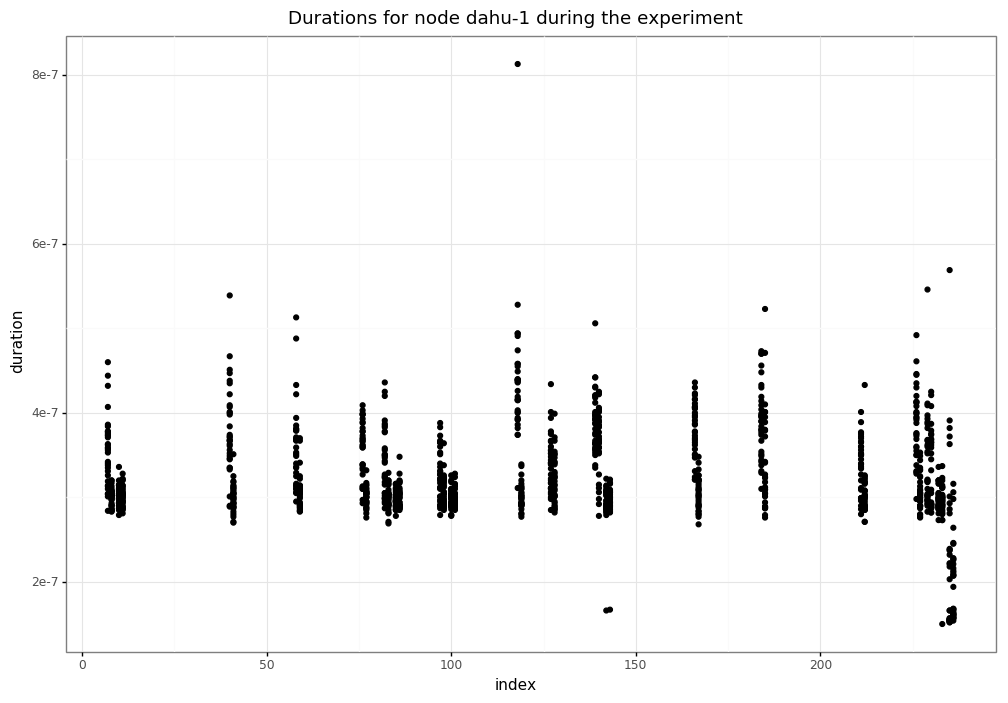

<ggplot: (-9223363274030602408)>


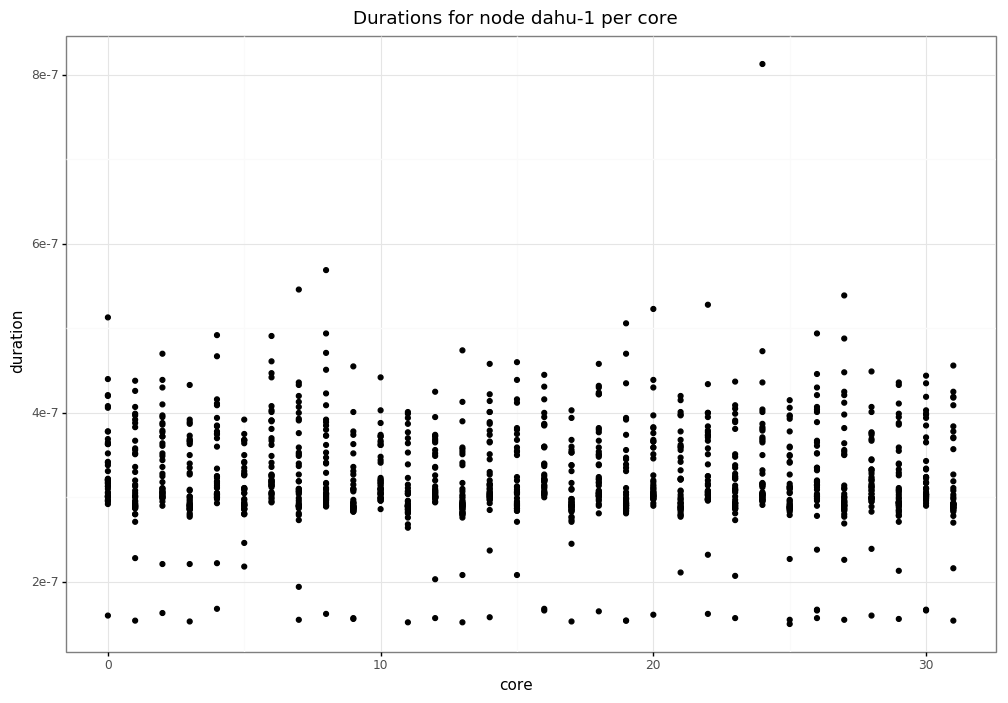

<ggplot: (-9223363274103330118)>


In [19]:
summary_plot_node(df_monocore, 'dgemm', 4, 1)

### DTRSM, N=4

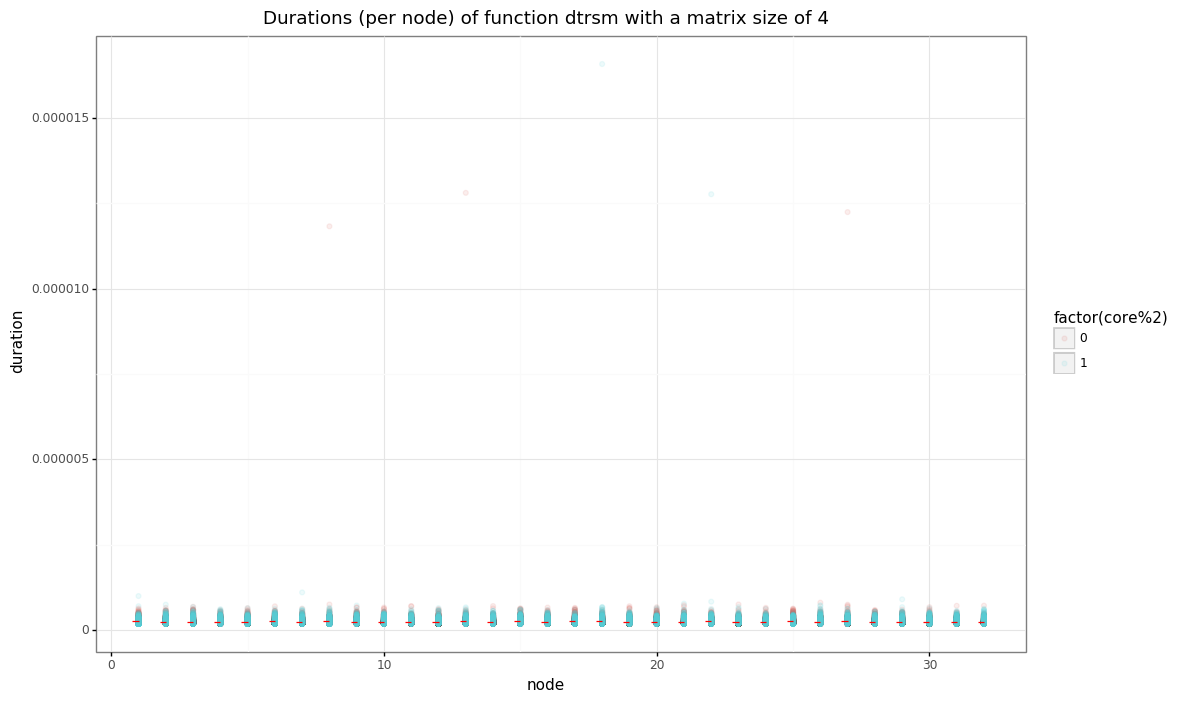

<ggplot: (-9223363274030534014)>

In [20]:
summary_plot(df_monocore, 'dtrsm', 4, color='factor(core%2)')

### DGEMM vs DTRSM

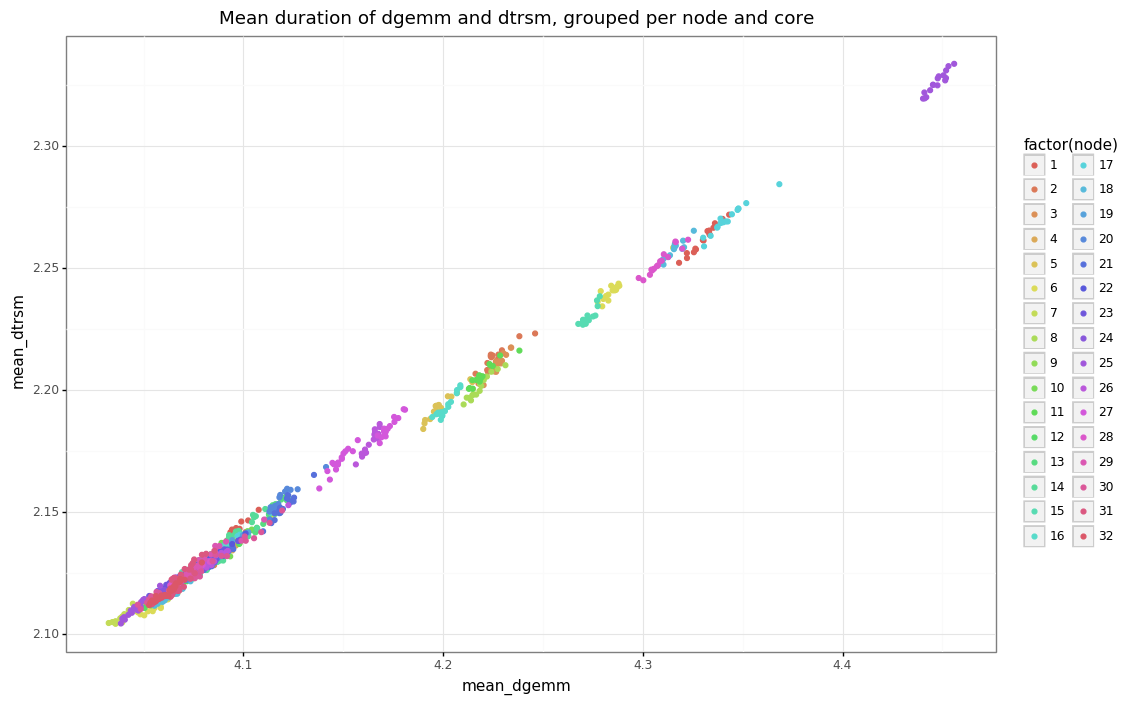

<ggplot: (8762751681456)>

In [21]:
agg = summary(df_monocore[df_monocore['m'] == 4000], ['function', 'node', 'core'])
agg['node:core'] = agg['node'].astype(str) + ':' + agg['core'].astype(str)
agg_dgemm = agg[agg['function'] == 'dgemm']
agg_dtrsm = agg[agg['function'] == 'dtrsm']
agg = agg_dgemm.set_index('node:core').join(agg_dtrsm.set_index('node:core'), rsuffix='_dtrsm').reset_index()
agg['mean_dgemm'] = agg['mean']
ggplot(agg, aes(x='mean_dgemm', y='mean_dtrsm', color='factor(node)')) + geom_point() + theme_bw() + ggtitle('Mean duration of dgemm and dtrsm, grouped per node and core')

In [22]:
agg_dgemm[['mean', 'std', 'min', 'max']].describe()

,mean,std,min,max
count,1024.000000,1024.000000,1024.000000,1024.000000
mean,4.122219,0.006099,4.111710,4.133080
std,0.087229,0.006573,0.080890,0.095747
min,4.032496,0.000795,4.030418,4.034993
25%,4.070552,0.002024,4.064512,4.075236
50%,4.084114,0.003040,4.078482,4.089538
75%,4.138811,0.006658,4.125269,4.156284
max,4.455925,0.031796,4.420120,4.515469


In [23]:
agg_dtrsm[['mean', 'std', 'min', 'max']].describe()

,mean,std,min,max
count,1024.000000,1024.000000,1024.000000,1024.000000
mean,2.151647,0.003724,2.145846,2.159640
std,0.047503,0.003561,0.044122,0.053172
min,2.104328,0.000336,2.099001,2.105469
25%,2.122911,0.001368,2.119550,2.126397
50%,2.130468,0.002226,2.126767,2.134949
75%,2.163818,0.004610,2.154387,2.177845
max,2.333468,0.016787,2.313763,2.374482


In [24]:
(agg_dgemm['max']/agg_dgemm['min']).describe()

count    1024.000000
mean        1.005136
std         0.004757
min         1.000816
25%         1.001947
50%         1.002922
75%         1.006657
max         1.021868
dtype: float64

In [25]:
(agg_dtrsm['max']/agg_dtrsm['min']).describe()

count    1024.000000
mean        1.006354
std         0.005470
min         1.000706
25%         1.002575
50%         1.003989
75%         1.008082
max         1.026309
dtype: float64

## Anova with CPU instead of node

We saw that performance inside a node is often bimodal: even cores in one mode, odd cores in another mode. This can be explained by the topology of the nodes (see below picture). The nodes have two sockets, the even nodes are on a same CPU, the odd nodes on the other CPU.

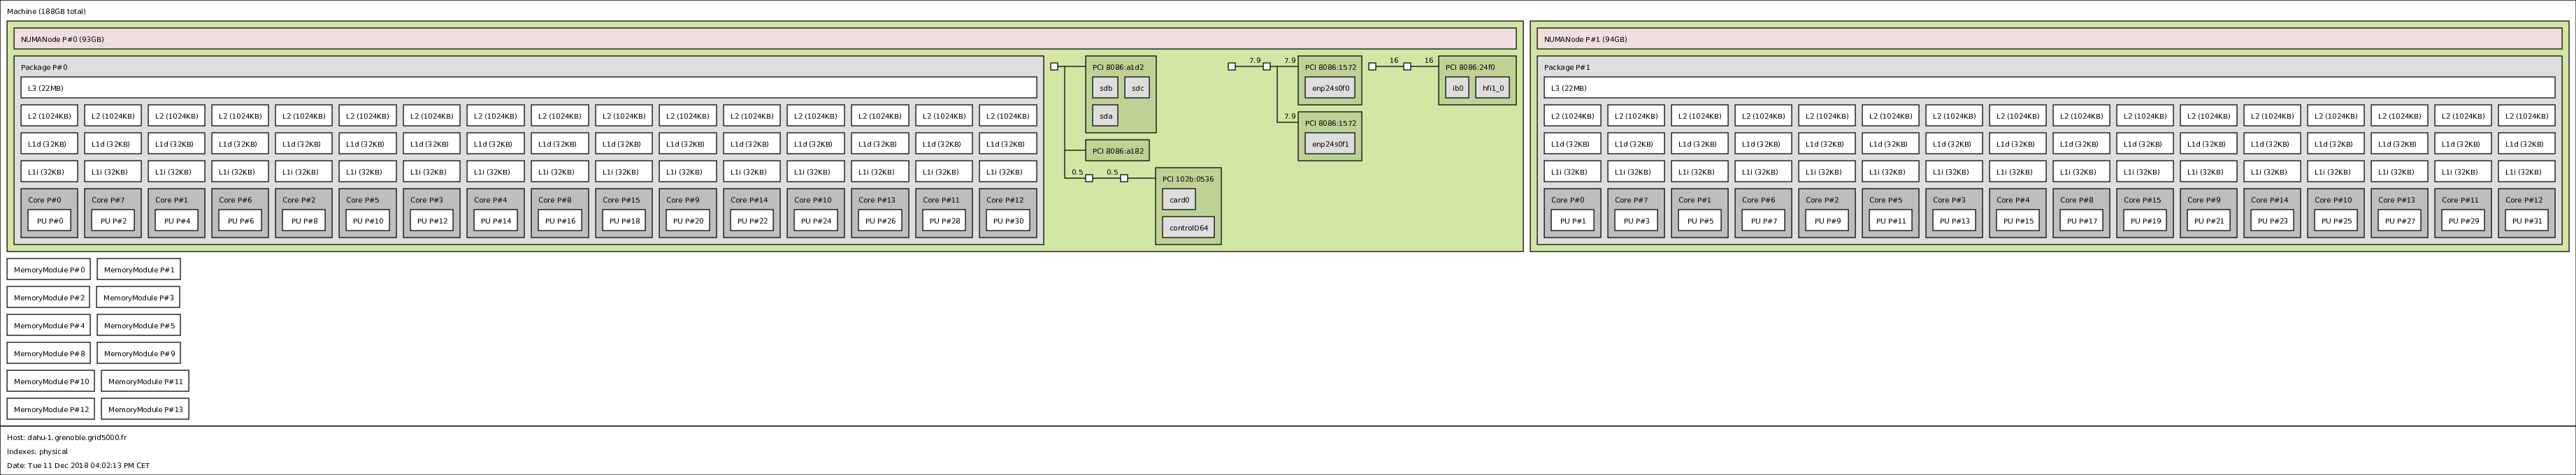

In [26]:
!unzip -p heterogeneity_exp/4/grenoble_2018-12-11_1826515.zip information/dahu-1.grenoble.grid5000.fr/topology.pdf > /tmp/topo.pdf
!convert /tmp/topo.pdf /tmp/topo.png
from IPython.display import Image
Image(filename='/tmp/topo.png', unconfined=True)

In [27]:
df_monocore['cpu'] = df_monocore['node'] + df_monocore['core%2']
df_monocore['core_in_cpu'] = (df_monocore['core'] / 2).astype(int)
df_monocore.head()

,function,m,n,k,timestamp,duration,node,index,index_in_seq,first_index,core,size_cube,core%2,cpu,core_in_cpu
1,dtrsm,4.0,4.0,-1.0,754.354763,5.430000e-07,21,1,1,False,0,6.400000e+01,0,21,0
2,dtrsm,4.0,4.0,-1.0,754.354766,2.500000e-07,21,2,2,False,0,6.400000e+01,0,21,0
4,dtrsm,4000.0,4000.0,-1.0,756.520683,2.168003e+00,21,4,1,False,0,6.400000e+10,0,21,0
5,dtrsm,4000.0,4000.0,-1.0,758.688693,2.172393e+00,21,5,2,False,0,6.400000e+10,0,21,0
7,dgemm,4.0,4.0,4.0,760.861098,3.410000e-07,21,7,1,False,0,6.400000e+01,0,21,0


In [28]:
def compute_anova2(df, function, m):
    df = df[(df['function'] == function) & (df['m'] == m)]
    return my_anova(df, factors=['cpu', 'core_in_cpu'], response='duration')

In [29]:
compute_anova2(df_monocore, 'dtrsm', 4)

,sum_sq,df,F,PR(>F),stars
C(cpu),1.324164e-12,32.0,1.586771,1.879261e-02,*
C(core_in_cpu),3.697677e-12,15.0,9.452798,1.129224e-22,***
C(cpu):C(core_in_cpu),1.500992e-11,480.0,1.199113,1.851996e-03,**
Residual,1.054393e-09,40432.0,NaN,NaN,


In [30]:
compute_anova2(df_monocore, 'dgemm', 4)

,sum_sq,df,F,PR(>F),stars
C(cpu),1.072656e-12,32.0,4.733356,2.069873e-17,***
C(core_in_cpu),8.058676e-14,15.0,0.758632,7.252431e-01,
C(cpu):C(core_in_cpu),3.051531e-12,480.0,0.897708,9.465045e-01,
Residual,2.863299e-10,40432.0,NaN,NaN,


In [31]:
compute_anova2(df_monocore, 'dtrsm', 4000)

,sum_sq,df,F,PR(>F),stars
C(cpu),44.810145,32.0,1177.978271,0.000000e+00,***
C(core_in_cpu),0.245164,15.0,13.749175,1.440794e-35,***
C(cpu):C(core_in_cpu),0.277433,480.0,0.486215,1.000000e+00,
Residual,48.063381,40432.0,NaN,NaN,


In [32]:
compute_anova2(df_monocore, 'dgemm', 4000)

,sum_sq,df,F,PR(>F),stars
C(cpu),150.327288,32.0,1164.388233,0.000000e+00,***
C(core_in_cpu),0.442019,15.0,7.303979,2.075270e-16,***
C(cpu):C(core_in_cpu),0.673356,480.0,0.347707,1.000000e+00,
Residual,163.123023,40432.0,NaN,NaN,
